<a href="https://colab.research.google.com/github/rg-smith/remote-sensing-hydro-2026/blob/main/lectures/lecture2-vector-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geospatial Programming Demo (Beginner-friendly)

### 🎯 Goal
We will combine **tabular well data**, **map boundaries (Corcoran Clay)**, and **time-series groundwater measurements** to explore how groundwater levels vary across space and time.

The objective is to:
1. Load CSV files and explore their columns and structure
2. Convert latitude/longitude into a map layer (GeoDataFrame of wells)
3. Clip the wells only inside the Corcoran Clay Layer
4. Filter groundwater data
5. Compute yearly average groundwater levels for each well
7. Summarize regional groundwater trends using mean, median, and quartiles
8. Visualize results using maps and time-series plots for any wells



# Step 1: Install Geospatial Libraries

Google Colab does not include most geospatial libraries by default,  
so we must install them at the start of each session.


In [ ]:
!pip -q install geopandas shapely


### What does this command mean?

- `pip` → Python package manager (downloads and installs libraries)
- `!` → run as a system (terminal) command, not Python code
- `-q` → quiet mode (less text printed)

This installs the libraries only for this Colab session.  
If you restart the notebook, you must install them again.


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point


print("All geospatial libraries loaded successfully!")


All geospatial libraries loaded successfully!


### Why do we need these libraries?

- **GeoPandas** → works with spatial vector data (shapefiles, GeoJSON, points, lines, polygons)  
  Example: wells, boundaries, Corcoran Clay outline

- **Point (shapely)** → create a location from coordinates so we can test if it lies inside a boundary or near other features


Together, these tools allow us to:

- read vector and raster geospatial data
- align datasets using projections
- analyze spatial relationships
- visualize maps in Python

This is the basic Python toolkit for geospatial data science.


In [ ]:
# Upload files from your computer (for example, a shapefile or GeoJSON of Corcoran Clay).
# After running this cell, choose the file(s) from your laptop to load them into Colab.
from google.colab import files
uploaded = files.upload()

# Show the names of the uploaded files so we can confirm they were added successfully
print("Uploaded:", list(uploaded.keys()))



Uploaded: []


In [ ]:
# Read the station (wells) data from a CSV file into a table (DataFrame)
wells_df = pd.read_csv("stations.csv")

# Read the groundwater measurement data from a CSV file into a table (DataFrame)
gw_df = pd.read_csv("measurements.csv")

# Print the column names in the wells table so we know what information is available
print("Wells columns:", wells_df.columns.tolist())

# Print the column names in the groundwater measurements table
print("GW columns:", gw_df.columns.tolist())

# Display the first 5 rows of the wells table to see what the data looks like
wells_df.head()


Wells columns: ['site_code', 'stn_id', 'swn', 'well_name', 'continuous_data_station_number', 'latitude', 'longitude', 'gse', 'rpe', 'gse_method', 'gse_acc', 'basin_code', 'basin_name', 'county_name', 'well_depth', 'well_use', 'well_type', 'wcr_no', 'monitoring_program']
GW columns: ['site_code', 'msmt_date', 'gse_gwe']


,site_code,stn_id,swn,well_name,continuous_data_station_number,latitude,longitude,gse,rpe,gse_method,gse_acc,basin_code,basin_name,county_name,well_depth,well_use,well_type,wcr_no,monitoring_program
0,320000N1140000W001,51445,NaN,Bay Ridge,NaN,36.56048,-121.75463,545.92,545.92,Unknown,Unknown,NaN,NaN,Monterey,386.0,Residential,Part of a nested/multi-completion well,NaN,VOLUNTARY
1,325450N1171061W001,25067,19S02W05K003S,19S02W05K003S,NaN,32.54500,-117.10610,17.14,17.14,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,VOLUNTARY
2,325450N1171061W002,25068,19S02W05K004S,19S02W05K004S,NaN,32.54500,-117.10610,17.14,17.14,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,VOLUNTARY
3,325450N1171061W003,39833,19S02W05K005S,19S02W05K005S,NaN,32.54500,-117.10610,17.14,17.14,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,VOLUNTARY
4,325450N1171061W004,25069,19S02W05K006S,19S02W05K006S,NaN,32.54500,-117.10610,17.14,17.14,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,VOLUNTARY


In [ ]:
# Create a GeoDataFrame (spatial table) from the wells table so we can plot points on a map

# Make a copy of the wells table so we don’t change the original DataFrame
wells_gdf = gpd.GeoDataFrame(
    wells_df.copy(),

    # Create point geometries from longitude and latitude columns
    geometry=gpd.points_from_xy(wells_df["longitude"], wells_df["latitude"]),

    # Set the coordinate reference system (CRS) to NAD83 (common for US datasets)
    crs="EPSG:4269"
)

# Display the first 5 rows to confirm geometry was created correctly
wells_gdf.head()



,site_code,stn_id,swn,well_name,continuous_data_station_number,latitude,longitude,gse,rpe,gse_method,gse_acc,basin_code,basin_name,county_name,well_depth,well_use,well_type,wcr_no,monitoring_program,geometry
0,320000N1140000W001,51445,NaN,Bay Ridge,NaN,36.56048,-121.75463,545.92,545.92,Unknown,Unknown,NaN,NaN,Monterey,386.0,Residential,Part of a nested/multi-completion well,NaN,VOLUNTARY,POINT (-121.75463 36.56048)
1,325450N1171061W001,25067,19S02W05K003S,19S02W05K003S,NaN,32.54500,-117.10610,17.14,17.14,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,VOLUNTARY,POINT (-117.1061 32.545)
2,325450N1171061W002,25068,19S02W05K004S,19S02W05K004S,NaN,32.54500,-117.10610,17.14,17.14,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,VOLUNTARY,POINT (-117.1061 32.545)
3,325450N1171061W003,39833,19S02W05K005S,19S02W05K005S,NaN,32.54500,-117.10610,17.14,17.14,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,VOLUNTARY,POINT (-117.1061 32.545)
4,325450N1171061W004,25069,19S02W05K006S,19S02W05K006S,NaN,32.54500,-117.10610,17.14,17.14,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,VOLUNTARY,POINT (-117.1061 32.545)


In [ ]:
# Read the Corcoran Clay shapefile as a GeoDataFrame (polygon map layer)
cc_gdf = gpd.read_file("corcoran_clay_extent.shp")

# Print the coordinate reference system (CRS) to check what map projection it uses
print("Corcoran Clay CRS:", cc_gdf.crs)

# Display the first 5 rows to see the attribute table of the clay layer
cc_gdf.head()



Corcoran Clay CRS: PROJCS["NAD_1983_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-120],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


,CLAY,geometry
0,yes,"POLYGON ((-94489.187 1632032.125, -89609.547 1..."


In [ ]:
# Reproject the wells GeoDataFrame so it uses the same coordinate system as the Corcoran Clay layer
# (Both layers must be in the same CRS to overlay them correctly on a map)
wells_gdf_proj = wells_gdf.to_crs(cc_gdf.crs)

# Print the CRS to confirm that the wells and clay layer now match
print("Wells projected CRS:", wells_gdf_proj.crs)



Wells projected CRS: PROJCS["NAD_1983_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-120],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [ ]:
# Keep only wells that fall inside the Corcoran Clay polygon using a spatial join
# This checks which well points are located within the clay boundary
wells_in_cc = gpd.sjoin(
    wells_gdf_proj,
    cc_gdf,
    predicate="within",
    how="inner"
).drop(columns=["index_right"])

# Print how many wells we started with and how many are inside Corcoran Clay
print("Wells total:", len(wells_gdf), "| Wells in Corcoran Clay:", len(wells_in_cc))

# Display the first 5 wells that are inside the clay layer
wells_in_cc.head()


Wells total: 47378 | Wells in Corcoran Clay: 13023


,site_code,stn_id,swn,well_name,continuous_data_station_number,latitude,longitude,gse,rpe,gse_method,...,basin_code,basin_name,county_name,well_depth,well_use,well_type,wcr_no,monitoring_program,geometry,CLAY
16573,350033N1189366W001,30732,11N19W29N001S,RMW-WWB-010,NaN,35.00191,-118.93212,961.03,961.19,GPS,...,5-022.18,White Wolf,Kern,1220.0,Observation,Single Well,NaN,SGMA,POINT (96657.039 1327557.567),yes
16624,350092N1189220W001,11437,11N19W29G001S,11N19W29G001S,NaN,35.00920,-118.92200,894.52,895.02,Unknown,...,5-022.18,White Wolf,Kern,NaN,Unknown,Unknown,NaN,VOLUNTARY,POINT (97563.739 1328383.506),yes
16658,350128N1189084W001,30731,11N19W28G001S,B1,NaN,35.01255,-118.90850,871.00,872.00,Unknown,...,5-022.18,White Wolf,Kern,1094.0,Irrigation,Single Well,NaN,VOLUNTARY,POINT (98781.19 1328772.249),yes
16686,350162N1189360W001,51680,11N19W30A001S,PA-1,NaN,35.01619,-118.93596,852.00,852.00,USGS quad,...,5-022.18,White Wolf,Kern,1168.0,Irrigation,Single Well,Unknown,VOLUNTARY,POINT (96291.594 1329151.308),yes
16687,350164N1189274W001,11429,11N19W20P001S,11N19W20P001S,NaN,35.01640,-118.92740,847.52,849.52,Unknown,...,5-022.18,White Wolf,Kern,NaN,Unknown,Single Well,NaN,VOLUNTARY,POINT (97065.944 1329183.511),yes


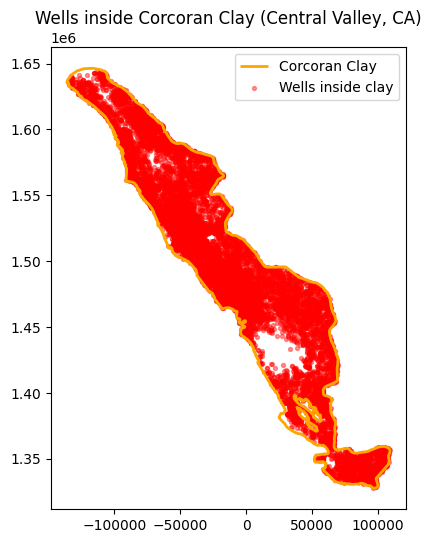

In [ ]:
# Create a new figure (the whole image) and an axis (the actual plotting area)
fig, ax = plt.subplots(figsize=(7, 6))

# Plot only the boundary (outline) of the Corcoran Clay polygon layer on the existing axis
# .boundary means we draw just the edges of the polygon, not the filled area
cc_gdf.boundary.plot(ax=ax, linewidth=2, color="orange", label="Corcoran Clay")

# Plot the wells that are located inside the Corcoran Clay polygon as red points
wells_in_cc.plot(
    ax=ax,              # draw on the same axis so both layers appear on the same map
    markersize=8,       # size of each well point
    color="red",        # color of the well points
    alpha=0.4,          # transparency (0 = invisible, 1 = fully solid)
    label="Wells inside clay"  # text shown in the legend
)

# Add a title to explain what the map shows
ax.set_title("Wells inside Corcoran Clay (Central Valley, CA)")

# Add a legend so we know what each color represents
ax.legend()

# Display the map
plt.show()



In [ ]:
# Keep only groundwater measurements that belong to wells inside the Corcoran Clay area

# Merge the groundwater measurements table with the list of wells inside Corcoran Clay
# This keeps only rows where the site_code exists in both tables
gw_cc = gw_df.merge(
    wells_in_cc[["site_code"]].drop_duplicates(),  # use only unique site codes from wells inside clay
    on="site_code",                                # match rows using the site_code column
    how="inner")                                    # keep only matching rows (intersection of both tables)



In [ ]:
# Keep a copy of the original date strings so we can check them later if needed
gw_cc["msmt_date_raw"] = gw_cc["msmt_date"]

# Convert the measurement date column to true datetime format (handles mixed date styles safely)
# errors="coerce" means invalid dates will become NaT (missing) instead of crashing the code
gw_cc["msmt_date"] = pd.to_datetime(gw_cc["msmt_date_raw"], errors="coerce", format="mixed")

# ---- Create a mask to keep only spring-season measurements (Jan 1 to April 1) ----
spring_mask = (
    (gw_cc["msmt_date"].dt.month < 4) |                     # January, February, March
    ((gw_cc["msmt_date"].dt.month == 4) & (gw_cc["msmt_date"].dt.day <= 1))  # April 1 only
)

# Apply the spring filter to keep only spring measurements
gw_cc_spring = gw_cc[spring_mask].copy()

# Extract the year from the measurement date (from the SPRING-filtered data)
gw_cc_spring["year"] = gw_cc_spring["msmt_date"].dt.year

# ---- Keep only data between years 1980 and 2023 ----
gw_cc_spring = gw_cc_spring[
    (gw_cc_spring["year"] >= 1980) & (gw_cc_spring["year"] <= 2023)
].copy()

# ---- Compute yearly average groundwater value for each well ----
# For each site_code and each year, take the mean of all spring measurements
gw_yearly_avg = (
    gw_cc_spring
    .dropna(subset=["msmt_date", "year", "gse_gwe"])         # remove rows with missing values
    .groupby(["site_code", "year"], as_index=False)["gse_gwe"]
    .mean()
)

# Display the first 5 rows of the yearly-averaged table
gw_yearly_avg.head()


In [ ]:
# Count how many different years of data each well (site_code) has
# nunique() counts unique year values for each well
years_per_well = gw_yearly_avg.groupby("site_code")["year"].nunique()

# Select only the wells that have at least 10 years of data
valid_sites = years_per_well[years_per_well >= 10].index

# Keep only rows in the yearly table that belong to those valid wells
gw_yearly_avg_10yr = gw_yearly_avg[gw_yearly_avg["site_code"].isin(valid_sites)].copy()

# Print how many wells passed the 10-year requirement
print("Number of wells with ≥10 years:", len(valid_sites))

# Print the size (rows, columns) of the filtered yearly-average table
print("Rows after filtering:", gw_yearly_avg_10yr.shape)



In [ ]:
# Keep only the well locations that belong to wells with at least 10 years of data
# This filters the spatial (map) layer using the list of valid site codes
wells_10yr = wells_in_cc[wells_in_cc["site_code"].isin(valid_sites)].copy()


In [ ]:
# Create a new figure and axis for plotting the map
fig, ax = plt.subplots(figsize=(7, 6))

# Plot only the boundary (outline) of the Corcoran Clay polygon
cc_gdf.boundary.plot(ax=ax, linewidth=2, color="orange", label="Corcoran Clay")

# Plot the well locations that have at least 10 years of spring data inside the clay layer
wells_10yr.plot(
    ax=ax,                                      # plot on the same map axis
    markersize=8,                               # size of the well points
    color="green",                              # color of the points
    alpha=0.4,                                  # transparency of the points
    label="Wells inside clay (≥10 years spring data)"  # legend label
)

# Add a title explaining what the map shows (line break using \n)
ax.set_title(
    "Wells inside Corcoran Clay (Central Valley, CA)\nwith at least 10 years of spring-season data"
)

# Place the legend outside the plot area so it does not cover the map
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Adjust layout so labels and legend fit nicely
plt.tight_layout()

# Display the final map
plt.show()



In [ ]:
valid_sites

In [ ]:
# Calculate summary statistics across all wells for each year

stats_by_year = (
    gw_yearly_avg_10yr
    # Group the data by year (combines all wells together for each year)
    .groupby("year")["gse_gwe"]

    # Compute summary statistics for each year
    .agg(
        mean="mean",                               # average groundwater value across wells
        median="median",                           # middle value across wells
        q1=lambda s: s.quantile(0.25),             # 25th percentile (lower quartile)
        q3=lambda s: s.quantile(0.75),             # 75th percentile (upper quartile)
    )

    # Convert grouped result back into a normal table with a 'year' column
    .reset_index()
)



In [ ]:
# Create a 2x2 grid of subplots (4 plots total) in one figure
# sharex/sharey keeps the same x- and y-axis scale across all panels for easy comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharex=True, sharey=True, constrained_layout=True)

# Convert the 2D array of axes into a 1D list so we can loop through them easily
axes = axes.ravel()

# Define what we want to plot in each panel: (column name in stats_by_year, plot title, line color)
series = [
    ("mean", "Mean", "tab:blue"),
    ("median", "Median", "tab:orange"),
    ("q1", "Q1 (25th percentile)", "tab:green"),
    ("q3", "Q3 (75th percentile)", "tab:red"),
]

# Remove the 'date' column if it exists (we are plotting using numeric years, not datetime)
stats_by_year = stats_by_year.drop(columns=["date"], errors="ignore")

# Use the year column as the x-axis values
x = stats_by_year["year"].values

# Loop through each subplot and each statistic (mean/median/q1/q3)
for ax, (col, title, color) in zip(axes, series):

    # Plot the statistic as a line with markers
    ax.plot(
        x,                          # x-axis: year
        stats_by_year[col].values,  # y-axis: the statistic values for that year
        linewidth=2.8,              # thickness of the line
        marker="o",                 # circle marker at each year
        markersize=4,               # marker size
        color=color                 # line color (different for each statistic)
    )

    # Add a title to each subplot
    ax.set_title(title, fontsize=13, fontweight="bold", pad=8)

    # Add x-axis and y-axis labels on every subplot
    ax.set_xlabel("Year", fontsize=11)
    ax.set_ylabel("Depth to groundwater (ft)", fontsize=11)

    # Add a light grid to make it easier to read values
    ax.grid(True, alpha=0.25)

    # Add minor ticks for a cleaner, more detailed axis
    ax.minorticks_on()

    # Control tick label size for readability
    ax.tick_params(axis="both", labelsize=10)

    # Show x-axis ticks every 5 years to avoid crowded labels
    ax.set_xticks(list(range(int(x.min()), int(x.max()) + 1, 5)))

# Add an overall title for the entire figure
fig.suptitle(
    "Depth to groundwater summary (wells with ≥10 years) — spring yearly stats (1980–2023)",
    fontsize=16, fontweight="bold", y=1.02
)

# Display the figure
plt.show()



In [ ]:
print (stats_by_year)

In [ ]:

# Ask the user to type a site code (well ID) to explore
site_code_input = input("Enter site_code: ").strip()

# -----------------------------
# Get yearly groundwater data for the selected well
# -----------------------------
df_site = gw_yearly_avg[
    gw_yearly_avg["site_code"].astype(str) == site_code_input
].copy()

# -----------------------------
# Get the map location of the selected well (from wells with ≥10 years of data)
# -----------------------------
site_pt = wells_10yr[
    wells_10yr["site_code"].astype(str) == site_code_input
].copy()

# -----------------------------
# Check if the site exists in both datasets
# -----------------------------
if df_site.empty:
    print("No time-series data found for this site_code.")

elif site_pt.empty:
    print("Site code not found in wells_10yr (maybe not inside Corcoran Clay or not enough data).")

else:
    # Sort data by year so the time series is plotted correctly
    df_site = df_site.sort_values("year")

    # Create a figure with two panels: map (left) and time series (right)
    fig, (ax_map, ax_ts) = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

    # ===== LEFT PANEL: Map =====

    # Plot the Corcoran Clay boundary (outline only)
    cc_gdf.boundary.plot(ax=ax_map, linewidth=2, color="orange")

    # Plot the selected well as a red dot on the same map
    site_pt.plot(
        ax=ax_map,
        markersize=50,
        color="red",
        edgecolor="black",
        linewidth=1.2
    )

    # Add title and hide axis labels for a clean map
    ax_map.set_title("Station location inside Corcoran Clay")
    ax_map.set_axis_off()

    # ===== RIGHT PANEL: Time Series =====

    # Plot yearly average spring groundwater values for the selected well
    ax_ts.plot(
        df_site["year"],
        df_site["gse_gwe"],
        linewidth=2.5,
        marker="o",
        markersize=4
    )

    # Add grid and axis labels
    ax_ts.grid(True, alpha=0.25)
    ax_ts.set_xlabel("Year")
    ax_ts.set_ylabel("Depth to groundwater (ft)")

    # Add plot title using the site code
    ax_ts.set_title(f"Yearly average (spring) — {site_code_input}")

    # Show both plots
    plt.show()



In [ ]:
wells_10yr